In [1]:
import random
import math
import numpy as np
import Parsing_midi as pm
import Init_chromo as init
import Melody_matching as mm
import mido
from mido import Message, MidiFile, MidiTrack
from collections import Counter
import copy
import matplotlib.pyplot as plt
from itertools import combinations # product: 排列
import time
import multiprocessing as mp

### Seperate phrase
- one bar = 1920 (4 beats)
- sliding window = 7680 (4 bar)

In [2]:
midi_list = pm.get_midi('MidiSample/sky.mid', 0)

In [3]:
def trans_note_list(song):
    return [song[i].note for i in range(len(song))]

note_msg, midi_msg = pm.separate_song(midi_list, 15360)
parent = midi_msg[1]  # can change here for testing

def flatten_list(midi_list):
    return [item for sublist in midi_list for item in sublist]

In [4]:
## transform to C major (-3)
for i in range(len(parent)):
    parent[i].note = parent[i].note -3 # shift    
pm.to_midi_file(parent, 8 , 'ori.mid')

## 4 beats (1920) in one bar
note_msg, midi_msg = pm.separate_song(parent, 1920)
origin_note = [trans_note_list(midi_msg[i]) for i in range(len(midi_msg))]

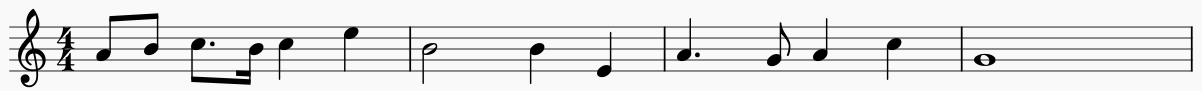

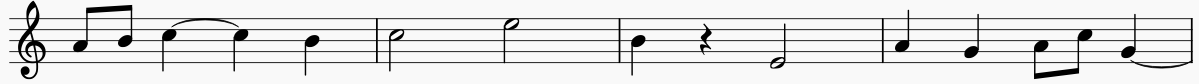

### Count CE   
#### [Paper reference](https://www.jstor.org/stable/pdf/3681713.pdf?refreqid=excelsior%3A161dc33b5d8b13a0a891837b552564c5)

In [5]:
pitch_ary = [[0,1,0],[-1,0,7],[0,-1,2],[1,0,9],[0,1,4],[-1,0,11],[0,-1,6], [1,0,1], [0,1,8],[-1,0,3],[0,-1,10],[1,0,5]]

## Get CE 
def count_unique(ary):
    u = []
    unique = [i for i in ary if i not in u]
    return unique, len(unique)

def count_CE(notes_seq):
    note_seq1, Dab = count_unique(notes_seq)
    sum_dp = 0
    for pij in note_seq1:
        dij = 1  # duration
        sum_dp += np.array(dij * pij)  
    CE = sum_dp/Dab
    return CE

# transform to coordinate
def trans_to_coordinate(seq):
    ary = []
    for i in range(len(seq)):
        if i % 2 == 0:
            pitch_ary[(seq[i].note) % 12][2] = seq[i].note
            ary.append(pitch_ary[(seq[i].note) % 12])
    return ary

def get_ce_list(midi_msg):
    xyz = [trans_to_coordinate(midi_msg[i]) for i in range(len(midi_msg))]    
    CE = [count_CE(xyz[i]) for i in range(len(xyz))]
    return CE

# compare thedistance between new ce (generate by computer) and the original ce
def count_distance(ori, new):
    return round(np.sqrt(sum(np.array(ori - new) ** 2)), 2) 

### Evolutionary algorithmn
- selection
- crossover
- mutation
- fitness

In [6]:
CE = get_ce_list(midi_msg)  # CE list from every bar

## Selection
def get_fitness_score(new_midi):
    score = 0
    global temp
    # melody matching
    ori = flatten_list(midi_msg)
    new = flatten_list(new_midi)
    smooth_area_score = mm.count_area_score(ori, new, smooth_curve=True)  # smooth
    area_score = mm.count_area_score(ori, new, smooth_curve=False)  

    for i in range(len(CE)): # 分小節計算分數
        ## encoding
        temp = copy.deepcopy(new_midi) # 整個midi
        note = trans_note_list(temp[i])# 取出一小節
        ## fitness
        _score, mid = fitness(temp[i], note, CE[i], origin_note[i]) # score per bar
        score += _score
    return score + area_score + smooth_area_score

def select_best(pop_list):  # used in initialization
    pop_idx = [i for i in range(len(pop_list))]
    score = -10000; pop1 = []; pop2 = []
    candidate = list(combinations(pop_idx, 2))
    for i in range(len(candidate)):
        individual1, individual2 = pop_list[candidate[i][0]], pop_list[candidate[i][1]]
        ind_note1, ind_midi1 = pm.separate_song(individual1, 1920) 
        ind_note2, ind_midi2 = pm.separate_song(individual2, 1920) 

        score1 = get_fitness_score(ind_midi1)  # several bars
        score2 = get_fitness_score(ind_midi2)

        total_score = score1 + score2
        if score < total_score :
            score = total_score
            pop1, pop2 = ind_midi1, ind_midi2
    return pop1, pop2, score

## Crossover
def crossover(parent, pop):
    ind1 = copy.deepcopy(parent)
    ind2 = copy.deepcopy(pop)
    crossover_point = random.randint(0,len(ind1))
    while crossover_point % 2 != 0 :
        crossover_point = random.randint(0,len(ind1))
    pop_midi1 = ind1[ :crossover_point] + ind2[crossover_point: ]
    pop_midi2 = ind2[ :crossover_point] + ind1[crossover_point: ]
    return pop_midi1, pop_midi2
    
## Mutation
def mutation(child): 
    temp = copy.deepcopy(child)
    mute_point = random.randint(0,len(temp)-1)  # choose the mutation point
    while mute_point % 2 != 0:
        mute_point = random.randint(0,len(temp)-1)
    mutate_note = init.get_note(temp[mute_point].note)
    if temp[mute_point].note + mutate_note > 50 and temp[mute_point].note + mutate_note < 90:
        temp[mute_point].note = temp[mute_point].note + mutate_note
        temp[mute_point + 1].note = temp[mute_point].note
    return temp


## Fitness
C_pitch = [0, -1, 2, -1, 4, 5, -1, 7, -1, 9, -1, 11]  # there is no sharp and flat in C scale, so set it as -1
chord_list = [[0,4,7],[-1,-1,-1],[2,5,9],[-1,-1,-1],[4,7,11],[5,9,0],[-1,-1,-1],[7,11,2],[-1,-1,-1],[9,0,4],[-1,-1,-1],[11,2,5]]
pitch_list = ['C','D','E','F','G','A','B']

def fitness(midi_msg, note_msg, chord, ori_note): # input type: list
    score_ce = 0; score_harmony = 0
    scale_list = [0,2,4,5,7,9,11]  # = midi notes = ['C','D','E','F','G','A','B']
    
    # rate the CE distance in each bar (30%)
    xyz_ = trans_to_coordinate(midi_msg)
    CE_ = count_CE(xyz_)  
    dist = count_distance(chord, CE_)  # compare new and old CE
    if dist == 0.0:  # the chord remain
        score_ce += 30
    elif dist > 0 and dist <= 2:
        score_ce += 25
    elif dist > 3 and dist <= 4:
        score_ce += 15
    elif dist > 4 and dist <= 8:
        score_ce += 5
    else:
        score_ce += 0     
    
    ## get chord note, ie: C major is CEG
    c = int(list(chord)[2])
    if c % 12 in C_pitch:
        chord = chord_list[c % 12]
    elif c + 1 % 12 in C_pitch:
        chord = chord_list[c + 1 % 12]
    elif c - 1 % 12 in C_pitch:
        chord = chord_list[c - 1 % 12]
    
    ## score every notes based on harmony rule (40%)
    for i in range(len(midi_msg)):  # TODO: if len==1
        if i % 2 == 0:
            if midi_msg[i].note in ori_note: # keep original melody
                score_harmony += 3
            elif midi_msg[i].note not in ori_note:
                score_harmony -= 2                         
            if midi_msg[i].note % 12 == chord[0]:  # if the note is chord root note
                score_harmony += 6
            elif midi_msg[i].note % 12 == chord[1]:  # if the note is 2nd note
                score_harmony += 4
            elif midi_msg[i].note % 12 == chord[2]:  # if the note is 3rd note
                score_harmony += 4            
            if i == 0 and midi_msg[i].note % 12 == chord[0]:  # the note is the first note and is a chord root note
                score_harmony += 6
            elif i == 0 and midi_msg[i].note % 12 == chord[1]:  # the note is the first note and is a 2nd chord note
                score_harmony += 4
            elif i == 0 and midi_msg[i].note % 12 == chord[2]:  # the note is the first note and is a 3rd chord note
                score_harmony += 4 
            if i == len(midi_msg)-2 and midi_msg[i].note % 12 == chord[0]: # the note is the last note and is a chord root note
                score_harmony += 6
            elif i == len(midi_msg)-2 and midi_msg[i].note % 12 == chord[1]: # the note is the last note and is a 2nd chord note
                score_harmony += 4
            elif i == len(midi_msg)-2 and midi_msg[i].note % 12 == chord[2]: # the note is the last note and is a 3rd chord note
                score_harmony += 4
            
            if i == 0 and midi_msg[i].note % 12 not in chord: # not in chord note
                score_harmony -= 5                   
            if i == len(midi_msg)-2 and midi_msg[i].note % 12 not in chord: # not in chord note
                score_harmony -= 5  
            if midi_msg[i].note % 12 not in chord: # note is not a chord note
                score_harmony -= 4
            if midi_msg[i].note % 12 not in scale_list:  # note not in the scale (C major)
                score_harmony -= 10              
            if i < len(midi_msg) - 3 and abs(midi_msg[i].note - midi_msg[i+2].note) >= 7:  # big jump notes
                score_harmony -= 10 
            if i < len(midi_msg) - 3 and abs(midi_msg[i].note - midi_msg[i+2].note) == 0:  # repetitive notes
                score_harmony -= 6                
            
            # duration
            if midi_msg[i].time - midi_msg[i+1].time > 65 and midi_msg[i].time - midi_msg[i+1].time < 125: 
                score_harmony += 8
            elif midi_msg[i].time - midi_msg[i+1].time < 65: # the duration of the note is too short
                score_harmony -= 5       
        score_harmony /= (len(midi_msg))   
        
    return int(score_ce + score_harmony)/4 , midi_msg  # 4 bar

#### [Reference paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7969627) 

### Main Function
- initialize: 17 combinations
- choose 2 highest score
- do crossover, mutation then generate 60 candicates
- choose 2 highest andidates become next populations

In [7]:
MUTATION_RATE = 0.4
CROSSOVER_RATE = 0.4
GENERATIONS = 200

## Initialize 
pop1 = init.add_note(parent, 479, 2)
pop2 = init.add_note(parent, 479, 2)
pop3 = init.add_note(parent, 479, 2)
pop4 = init.add_note(parent, 479, 2)
pop5 = init.add_note(parent, 239, 2)  
pop6 = init.add_note(parent, 479, 2)
pop7 = init.add_note(parent, 239, 3)
pop8 = init.add_note(parent, 239, 3)
pop9 = init.add_note(parent, 239, 2)
pop10 = init.add_note(parent, 239, 2)
pop11 = init.add_note(parent, 239, 2) 
pop12 = init.add_note(parent, 239, 2) 
pop13 = parent                                    # origin       
# pop14 = init.merge_duplicate_note(parent)         # duplicate note -> one note
# pop15 = init.change_duration(parent, 120, 480) # extend duration for 3 notes
# pop16 = init.change_duration(parent, 120, 480) # eliminate duration for 3 notes
# pop17 = init.remove_note(parent, 300)             # remove 1 note randomly

pop_list = [pop1, pop2, pop3, pop4, pop5, pop6, pop7, pop8, pop9, pop10, pop11, pop12, pop13]

In [ ]:
%%time

# Multiprocess crossover, mutation * N times
def job(candidateq, parent, pop): 
    candidate_list = []; count = 0
    for i in range(100):  
        # crossover
        crossover_rate = round(random.uniform(0, 1),1)
        if crossover_rate < CROSSOVER_RATE:
            crossover_c1, crossover_c2 = crossover(parent, pop)
        else:
            crossover_c1 = parent 
            crossover_c2 = pop
        # mutation
        mute_rate = round(random.uniform(0, 1),1)    
        if mute_rate < MUTATION_RATE:  
            mutation_c1 = mutation(crossover_c1)
            mutation_c2 = mutation(crossover_c2)
        elif mute_rate > MUTATION_RATE + 0.2:
            mutation_c1 = init.add_note(crossover_c1, 119, 1)
            mutation_c2 = init.add_note(crossover_c2, 239, 1)
        else:
            mutation_c1 = crossover_c1
            mutation_c2 = crossover_c2
        candidate_list.append(mutation_c1)
        candidate_list.append(mutation_c2)
    candidateq.put(candidate_list)

## get score from all candidates
def job2(scoreq,new_midi,a,b):
    t = []
    for i in range(a,b):
        score = 0
        ind_note1, ind_midi1 = pm.separate_song(new_midi[i], 1920)  
        score = get_fitness_score(ind_midi1)
        t.append([score, temp])
    scoreq.put(t)
    
def main():
    count = 0; score_list = []
    # choose 2 best candidate from initialization
    c1, c2, scr1 = select_best(pop_list)
    parent = flatten_list(c1)
    pop = flatten_list(c2)
    score_list.append(scr1)
    
    score_list = []
    while count < GENERATIONS:

        candidateq = mp.Queue()
        scoreq = mp.Queue()
    
        # generate condidates
        p1 = mp.Process(target = job, args = (candidateq, parent, pop))
        p1.start()
        candidate = candidateq.get()
        p1.join()
        
        # calculate score
        p2 = mp.Process(target = job2, args = (scoreq,candidate, 0, len(candidate))) # 200 candidate
        p2.start()
        s = scoreq.get()
        p2.join()
        
        score = []; pop = [];  max_score = 0
        for i in range(len(s)):
            score.append(s[i][0]) # get score list
        max_idx = score.index(max(score))
        max_score = max(score)
        score_list.append(max_score) # only append highest score
        pop.append(s[max_idx]) # 1 candidate
        del s[max_idx]

        max_idx = score.index(max(score))
        pop.append(s[max_idx]) # 2 candidate

        parent = flatten_list(pop[0][1])
        pop = flatten_list(pop[1][1])
        
        # output midi
        pm.to_midi_file(parent, 1 , 'Output_midi/sky_{}_{}.mid'.format(str(max_score), str(count)))

        print("Generation", count, "\t: score", max_score)
        count += 1  
    
    # plot score
    plt.plot(score_list)
    plt.xlabel('generation')
    plt.ylabel('score')
    plt.show()
          
if __name__ == '__main__':
    main()   

Generation 0 	: score 95.0
Generation 1 	: score 95.0
Generation 2 	: score 95.0
Generation 3 	: score 100.0
Generation 4 	: score 100.25
Generation 5 	: score 100.25
Generation 6 	: score 100.25
Generation 7 	: score 100.5
Generation 8 	: score 100.5
Generation 9 	: score 100.5
Generation 10 	: score 100.5
Generation 11 	: score 100.5
Generation 12 	: score 100.5
Generation 13 	: score 100.5
Generation 14 	: score 100.5
Generation 15 	: score 100.5
Generation 16 	: score 100.5
Generation 17 	: score 100.5
Generation 18 	: score 100.5
Generation 19 	: score 100.5
Generation 20 	: score 100.5
Generation 21 	: score 100.5
Generation 22 	: score 100.5
Generation 23 	: score 100.5
Generation 24 	: score 100.5
Generation 25 	: score 100.5
Generation 26 	: score 100.5
Generation 27 	: score 100.5
Generation 28 	: score 100.5
Generation 29 	: score 100.5
Generation 30 	: score 100.5
Generation 31 	: score 100.5
Generation 32 	: score 100.5
Generation 33 	: score 100.5
Generation 34 	: score 1